# ROAD DAMAGE DETECTION

### USE CASE
- Create a model to detect the damaged road in Saudi Arabia to use in real time computer vision application.

### Dataset
- Used data set was a part of "roaddamagedataset" available on kaggle. Training label was created manually for the used data set sample.

- Image dataset can be found here on [kaggle]("https://www.kaggle.com/shahir/roaddamage").
  
- Training label can be found here on [kaggle]("https://www.kaggle.com/shahir/training-label").

### Model
- Created TensorFlow model which can detect damage roads and show defective road area in red boxes.
- This model is inspired by yolo, specifically yolo v3.

### Reason to select YOLO algorithm
- YOLO model has been selected due to it's performance on real time and fatser object detection. We are going to us this model in real  time computer vision application. So compared R-CNN and SSD object detection model YOLO is the best fit for our purpose.
- YOLO use one-stage detector strategy that help to increase the speead of object detection. 
- YOLO treat object detection as a regression problem, taking a given input image and simultaneously learning  bounding box coordinates and class labels.

In [1]:
# This jupyter note book used to run on Kaggle kernel.
# Import required libraries

import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import albumentations as albu
from tqdm.notebook import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/roaddamage/new/train.csv
/kaggle/input/roaddamage/new/test.csv
/kaggle/input/roaddamage/new/train/Adachi_20170913105151.jpg
/kaggle/input/roaddamage/new/train/Adachi_20170908100145.jpg
/kaggle/input/roaddamage/new/train/Adachi_20170908102742.jpg
/kaggle/input/roaddamage/new/train/Adachi_20170911101126.jpg
/kaggle/input/roaddamage/new/train/Adachi_20170908100929.jpg
/kaggle/input/roaddamage/new/train/Adachi_20170920144840.jpg
/kaggle/input/roaddamage/new/train/Adachi_20170911112335.jpg
/kaggle/input/roaddamage/new/train/Adachi_20170907134444.jpg
/kaggle/input/roaddamage/new/train/Adachi_20170907152212.jpg
/kaggle/input/roaddamage/new/train/Adachi_20170907134540.jpg
/kaggle/input/roaddamage/new/train/Adachi_20170907150853.jpg
/kaggle/input/roaddamage/new/test/Adachi_20170913113755.jpg
/kaggle/input/roaddamage/new/test/Adachi_20170908135838.jpg
/kaggle/input/roaddamage/new/test/Adachi_20170921160156.jpg
/kaggle/input/roaddamage/new/test/Adachi_20170912151343.jpg
/kaggle/inpu

## Load data

will begin by loading the labels data and extracting the bounding boxes (which I refer to as "bboxes" in the code) from the table.

In [2]:
labels = pd.read_csv('../input/training-label/train.csv')
labels.head()

,image_id,width,height,bbox
0,Adachi_20170908100929,600,600,"[70,284,361,462]"
1,Adachi_20170907134444,600,600,"[481,293,596,427]"
2,Adachi_20170911101126,600,600,"[301,352,342,417]"
3,Adachi_20170908100145,600,600,"[8,232,233,574]"
4,Adachi_20170907134540,600,600,"[6,284,203,503]"


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  11 non-null     object
 1   width     11 non-null     int64 
 2   height    11 non-null     int64 
 3   bbox      11 non-null     object
dtypes: int64(2), object(2)
memory usage: 480.0+ bytes


In the raw data each bounding box is in an array of length 4 but formatted as a string. The below block of code groups the bounding boxes by image id and places the bounding boxes as numpy arrays next to each image id. The image id can then be used to quickly retrieve all of the bounding boxes.

In [4]:
def group_boxes(group):
    boundaries = group['bbox'].str.split(',', expand=True)
    boundaries[0] = boundaries[0].str.slice(start=1)
    boundaries[3] = boundaries[3].str.slice(stop=-1)
    
    return boundaries.values.astype(float)

labels = labels.groupby('image_id').apply(group_boxes)

In [5]:
labels['Adachi_20170908100929'][0:5]

array([[ 70., 284., 361., 462.]])

With the labels extracted from the data I now need the images loaded as numpy arrays. At this point it is worth splitting the data into a training and validation dataset. As the dataset is small I will keep the majority of the images in the training dataset and only put the last ten images aside as a validation dataset. This may not be the best size to perform accurate validation but I think it is the right compromise considering the number of images available and the complexity of the task.

In [6]:
train_image_ids = np.unique(labels.index.values)[0:8]
val_image_ids = np.unique(labels.index.values)[8:-1]

With the ids split it's now time to load the images. To keep the training of the model relatively fast I will resize each image from (600,600) to (256,256). 

In [7]:
def load_image(file):
    image = Image.open('../input/roaddamage/new/train/' + image_id + ".jpg")
    image = image.resize((256, 256))
    
    return np.asarray(image)

In [8]:
train_pixels = {}
train_labels = {}

for image_id in tqdm(train_image_ids):
    train_pixels[image_id] = load_image(image_id)
    train_labels[image_id] = labels[image_id].copy() / 4

In [9]:
val_pixels = {}
val_labels = {}

for image_id in tqdm(val_image_ids):
    val_pixels[image_id] = load_image(image_id)    
    val_labels[image_id] = labels[image_id].copy() / 4

## Visualize images

Before going on it is worth having a look at some of the images and bounding boxes in the dataset. For that a few helper functions will be required. The below functions take an image id and the corresponding bounding boxes and return the bounding boxes drawn onto the image.

In [10]:
def draw_bboxes(image_id, bboxes):  
    image = Image.open('../input/roaddamage/new/train/'+ image_id + ".jpg")
    image = image.resize((256,256))
    
    draw = ImageDraw.Draw(image)
            
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    
    return np.asarray(image)


def draw_bbox(draw, bbox):
    x, y, width, height = bbox
    draw.rectangle([x, y, x + width, y + height], width=2, outline='red')

I'll also add a wrapper function to call this function multiple times for multiple images.

In [11]:
def show_images(image_ids, bboxes):
    pixels = []
    
    for image_id in image_ids:
        pixels.append(
            draw_bboxes(image_id, bboxes[image_id])
        )
    
    num_of_images = len(image_ids)
    fig, axes = plt.subplots(
        1, 
        num_of_images, 
        figsize=(5 * num_of_images, 5 * num_of_images)
    )
    
    for i, image_pixels in enumerate(pixels):
        axes[i].imshow(image_pixels)

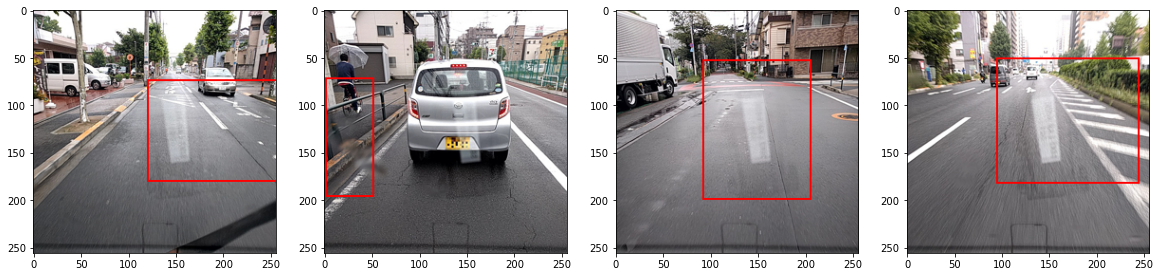

In [12]:
show_images(train_image_ids[0:4], train_labels)

In [13]:
def clean_labels(train_image_ids, train_labels):
    good_labels = {}
    
    for i, image_id in enumerate(train_image_ids):
        good_labels[image_id] = []
        
        for j, label in enumerate(train_labels[image_id]):

            # remove huge bbox
            if label[2] * label[3] > 8000 and i not in [1079, 1371, 2020]:
                continue

            # remove tiny bbox
            elif label[2] < 5 or label[3] < 5:
                continue
                
            else:
                good_labels[image_id].append(
                    train_labels[image_id][j]
                )
                
    return good_labels

train_labels = clean_labels(train_image_ids, train_labels)

## Data pipeline

Usually use Tensorflows data api or keras data generators to build a pipeline to get data into the model. However the pre-processing that needs to be done for this model is not trivial and it turned out to be easier to create a custom data generator. This takes the form of a class that is passed to keras' fit generator function. It contains the following functionality:

- define the size of the dataset. Keras needs this to work out how long an epoch is.
- shuffle the dataset.
- get an image and augment it to add variety to the dataset. 
- reshape the bounding boxes to a label grid.

I'll start by initialising the class.

In [14]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, image_ids, image_pixels, labels=None, batch_size=1, shuffle=False, augment=False):
        self.image_ids = image_ids
        self.image_pixels = image_pixels
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        self.image_grid = self.form_image_grid()
        
        
    def form_image_grid(self):    
        image_grid = np.zeros((32, 32, 4))

        # x, y, width, height
        cell = [0, 0, 256 / 32, 256 / 32] 

        for i in range(0, 32):
            for j in range(0, 32):
                image_grid[i,j] = cell

                cell[0] = cell[0] + cell[2]

            cell[0] = 0
            cell[1] = cell[1] + cell[3]

        return image_grid

Next add some methods to the class that keras needs to operate the data generation. length is used to determine how many images there are in the dataset. on_epoch_end is called at the end of each epoch (as well once before training starts) to get the index of all images in the dataset. It is also has the opportunity to shuffle the dataset per epoch if the generator was configured to do so.

In [15]:
def __len__(self):
    return int(np.floor(len(self.image_ids) / self.batch_size))


def on_epoch_end(self):
    self.indexes = np.arange(len(self.image_ids))

    if self.shuffle == True:
        np.random.shuffle(self.indexes)


DataGenerator.__len__ = __len__
DataGenerator.on_epoch_end = on_epoch_end

Regarding the augmentations a number of transformations will be applied to each training image before they are fed into the model. This helps to add some diversity to a small dataset effectively growing it to a much larger one:


In [16]:
DataGenerator.train_augmentations = albu.Compose([
        albu.RandomSizedCrop(
            min_max_height=(200, 200), 
            height=256, 
            width=256, 
            p=0.8
        ),
        albu.OneOf([
            albu.Flip(),
            albu.RandomRotate90(),
        ], p=1),
        albu.OneOf([
            albu.HueSaturationValue(),
            albu.RandomBrightnessContrast()
        ], p=1),
        albu.OneOf([
            albu.GaussNoise(),
            albu.GlassBlur(),
            albu.ISONoise(),
            albu.MultiplicativeNoise(),
        ], p=0.5),
        albu.Cutout(
            num_holes=8, 
            max_h_size=16, 
            max_w_size=16, 
            fill_value=0, 
            p=0.5
        ),
        albu.CLAHE(p=1),
        albu.ToGray(p=1),
    ], 
    bbox_params={'format': 'coco', 'label_fields': ['labels']})

DataGenerator.val_augmentations = albu.Compose([
    albu.CLAHE(p=1),
    albu.ToGray(p=1),
])

The next functions load an image and the corresponding bounding boxes depending on randomly picked image ids. As well as loading the images the above augmentations are added to an image as it is loaded. As the albumentaitons library was used to apply these augmentations I get the bounding boxes re-sized for free.

In [17]:
def __getitem__(self, index):
    indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    batch_ids = [self.image_ids[i] for i in indexes]

    X, y = self.__data_generation(batch_ids)

    return X, y


def __data_generation(self, batch_ids):
    X, y = [], []

    # Generate data
    for i, image_id in enumerate(batch_ids):
        pixels = self.image_pixels[image_id]
        bboxes = self.labels[image_id]

        if self.augment:     
            pixels, bboxes = self.augment_image(pixels, bboxes)
        else:
            pixels = self.contrast_image(pixels)
            bboxes = self.form_label_grid(bboxes)

        X.append(pixels)
        y.append(bboxes)

    return np.array(X), np.array(y)


def augment_image(self, pixels, bboxes):
    bbox_labels = np.ones(len(bboxes))

    aug_result = self.train_augmentations(image=pixels, bboxes=bboxes, labels=bbox_labels)

    bboxes = self.form_label_grid(aug_result['bboxes'])

    return np.array(aug_result['image']) / 255, bboxes


def contrast_image(self, pixels):        
    aug_result = self.val_augmentations(image=pixels)
    return np.array(aug_result['image']) / 255


DataGenerator.__getitem__ = __getitem__
DataGenerator.__data_generation = __data_generation
DataGenerator.augment_image = augment_image
DataGenerator.contrast_image = contrast_image

The final part of the data generator class re-shapes the bounding box labels. It's worth mentioning here that there are a number of ways to represent a bounding box with four numbers. Some common ways are coco (the shape the boxes are in the raw data), voc-pascal and yolo.

Will be using the yolo shape for this model. In addition to the above shape, yolo detects objects by placing a grid over the image and asking if an object (such as a road damage) is present in any of the cells of the grid. I've decided to use a 32x32 grid for this challenge which I'll refer to as a label grid. The bounding boxes are reshaped to be offset within the relevant cells of the image. Then all four variables (x, y, width and height) are scaled down to a 0-1 scale using the width and height of the image.


Any cells in the grid that have no objects within them contain a bounding box with the dimensions [0, 0, 0, 0].

Each bounding box gets a confidence score where a value of 1 tells us that an object (wheat head) is present in the cell and a value of 0 tells us that no object is present. So a cell with an object present could contain a value like this: [1, 0.5, 0.5, 0.2, 0.2] telling us that there is an object present (due to the confidence score of 1, the centre of the bounding box is exactly in the middle of the cell and the box is 20% of the images total width and height.

The below code takes the list of bounding boxes for an image and puts them into the yolo label grid shape.

In [18]:
def form_label_grid(self, bboxes):
    label_grid = np.zeros((32, 32, 10))

    for i in range(0, 32):
        for j in range(0, 32):
            cell = self.image_grid[i,j]
            label_grid[i,j] = self.rect_intersect(cell, bboxes)

    return label_grid


def rect_intersect(self, cell, bboxes): 
    cell_x, cell_y, cell_width, cell_height = cell
    cell_x_max = cell_x + cell_width 
    cell_y_max = cell_y + cell_height
    
    anchor_one = np.array([0, 0, 0, 0, 0])
    anchor_two = np.array([0, 0, 0, 0, 0])

    # check all boxes
    for bbox in bboxes:
        box_x, box_y, box_width, box_height = bbox
        box_x_centre = box_x + (box_width / 2)
        box_y_centre = box_y + (box_height / 2)

        if(box_x_centre >= cell_x and box_x_centre < cell_x_max and box_y_centre >= cell_y and box_y_centre < cell_y_max):
            
            if anchor_one[0] == 0:
                anchor_one = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
            
            elif anchor_two[0] == 0:
                anchor_two = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
                
            else:
                break

    return np.concatenate((anchor_one, anchor_two), axis=None)


def yolo_shape(self, box, cell):
    box_x, box_y, box_width, box_height = box
    cell_x, cell_y, cell_width, cell_height = cell

    # top left x,y to centre x,y
    box_x = box_x + (box_width / 2)
    box_y = box_y + (box_height / 2)

    # offset bbox x,y to cell x,y
    box_x = (box_x - cell_x) / cell_width
    box_y = (box_y - cell_y) / cell_height

    # bbox width,height relative to cell width,height
    box_width = box_width / 256
    box_height = box_height / 256

    return [1, box_x, box_y, box_width, box_height]


DataGenerator.form_label_grid = form_label_grid
DataGenerator.rect_intersect = rect_intersect
DataGenerator.yolo_shape = yolo_shape

In [19]:
train_generator = DataGenerator(
    train_image_ids,
    train_pixels,
    train_labels, 
    batch_size=2, 
    shuffle=True,
    augment=True
)

val_generator = DataGenerator(
    val_image_ids, 
    val_pixels,
    val_labels, 
    batch_size=2,
    shuffle=False,
    augment=False
)

image_grid = train_generator.image_grid

## Model

With the data ready to go I'll define and train the model. As mentioned before this model is inspired by yolo, specifically yolo v3. This is a large and at times complex model. Below is an outline of the model. Basically the model begins with a convolutional layer with 32 filters which doubles in size in the next layer. The filters are then halved in size before doubling every layer up to 128 layers. The filters are then halved again while a larger stride reduces the size of the input image. This pattern of doubling and halving filter sizes continues with a few repeated blocks until we reach a size of 1024. A few resnet skip layers are added in as well to stabilise the large number of layers and reduce the chance of vanishing gradients.

Below is keras implementation of the model. The model is mostly in line with the yolov3 architecture though I have removed a few layers and altered some others. 

In [20]:
x_input = tf.keras.Input(shape=(256,256,3))

x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

########## block 1 ##########
x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x


########## block 2 ##########
x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(2):
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 3 ##########
x = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    
########## block 4 ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(8):
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## block 5 ##########
x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x_shortcut = x

for i in range(4):
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Add()([x_shortcut, x])
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

########## output layers ##########
x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

predictions = tf.keras.layers.Conv2D(10, (1, 1), strides=(1, 1), activation='sigmoid')(x)

model = tf.keras.Model(inputs=x_input, outputs=predictions)

One issue with yolo is that it is likely to contain more cells in its label grid that contain no objects than cells that do contain objects. It is easy then for the model to focus too much on learning to reduce no object cells to zero and not focus enough on getting the bounding boxes to the right shape. To overcome this the yolo [paper](https://pjreddie.com/media/files/papers/YOLOv3.pdf) suggests weighting the cells containing bounding boxes five times higher and the cells with no bounding boxes by half. 

I have defined a custom loss function to do just this. I have also split the loss function into three parts. The first takes care of the confidence score that is trying to work out if a label grid cell contains a head of wheat or not. Binary cross entropy is used here as that is a binary classification task. The second part looks at the x,y position of the bounding boxes while the third looks at the width,height of the bounding boxes. MSE (mean squared loss) is used for the second and third parts as they are regression tasks. 

In [21]:
def custom_loss(y_true, y_pred):
    binary_crossentropy = prob_loss = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    
    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,0], y_true[:,:,:,5]], axis=0), 
        tf.concat([y_pred[:,:,:,0], y_pred[:,:,:,5]], axis=0)
    )
    
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,1:3], y_true[:,:,:,6:8]], axis=0), 
        tf.concat([y_pred[:,:,:,1:3], y_pred[:,:,:,6:8]], axis=0)
    )
    
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,3:5], y_true[:,:,:,8:10]], axis=0), 
        tf.concat([y_pred[:,:,:,3:5], y_pred[:,:,:,8:10]], axis=0)
    )
    
    bboxes_mask = get_mask(y_true)
    
    xy_loss = xy_loss * bboxes_mask
    wh_loss = wh_loss * bboxes_mask
    
    return prob_loss + xy_loss + wh_loss


def get_mask(y_true):
    anchor_one_mask = tf.where(
        y_true[:,:,:,0] == 0, 
        0.5, 
        5.0
    )
    
    anchor_two_mask = tf.where(
        y_true[:,:,:,5] == 0, 
        0.5, 
        5.0
    )
    
    bboxes_mask = tf.concat(
        [anchor_one_mask,anchor_two_mask],
        axis=0
    )
    
    return bboxes_mask

Adam is considered as optimizer. I have kept the learning rate reasonably high as it can take a number of steps to get the model moving quickly towards convergence. A higher rate helps to reduce the number of steps needed to get the model going.

In [22]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimiser, 
    loss=custom_loss
)


While a high learning rate at the beginning of a training run is great at the start, it can cause issues as the model approaches convergence when smaller, more careful steps are needed. I considered using learning rate decay to handle this but decided on a callback to reduce the learning rate when it plateaus (or increases) over the space of two epochs. This allows the model to make the most of a higher rate until it that rate is too high.

In addition to this I have added an early stopping callback to stop the model training if is no longer able to reduce the loss. This reduces any waste processing and provides faster feedback if the model just isn't training very well.


In [23]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True),
]

Finally the model is ready to be trained. The data generators are passed into the fit generator method of the model alongside the callbacks and the maximum number of epochs to take. Be warned that with 100 or less images this model can train at an okay speed on CPU. Any more images than that will need the GPU (which could still run for a few hours).

In [24]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    epochs=80,
    callbacks=callbacks
)

Epoch 1/80
4/4 [==============================] - 83s 21s/step - loss: 1.0315 - val_loss: 1.2114
Epoch 2/80
4/4 [==============================] - 81s 20s/step - loss: 0.8210 - val_loss: 0.9226
Epoch 3/80
4/4 [==============================] - 81s 20s/step - loss: 0.7026 - val_loss: 0.8626
Epoch 4/80
4/4 [==============================] - 81s 20s/step - loss: 0.6315 - val_loss: 0.8064
Epoch 5/80
4/4 [==============================] - 80s 20s/step - loss: 0.5966 - val_loss: 0.7694
Epoch 6/80
4/4 [==============================] - 80s 20s/step - loss: 0.5412 - val_loss: 0.7625
Epoch 7/80
4/4 [==============================] - 80s 20s/step - loss: 0.4960 - val_loss: 0.8137
Epoch 8/80
4/4 [==============================] - 81s 20s/step - loss: 0.4597 - val_loss: 0.8623
Epoch 9/80
4/4 [==============================] - 80s 20s/step - loss: 0.4378 - val_loss: 0.8007
Epoch 10/80
4/4 [==============================] - 80s 20s/step - loss: 0.4358 - val_loss: 0.8420
Epoch 11/80
4/4 [============

## Prediction post processing

The model outputs the predicted bounding boxes as a label grid. However to visualise the bounding boxes on an image  the shape for one images bounding boxes need change. 

This first function transforms the boxes from the yolo format to the coco format. 


In [25]:
def prediction_to_bbox(bboxes, image_grid):    
    bboxes = bboxes.copy()
    
    im_width = (image_grid[:,:,2] * 32)
    im_height = (image_grid[:,:,3] * 32)
    
    # descale x,y
    bboxes[:,:,1] = (bboxes[:,:,1] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,2] = (bboxes[:,:,2] * image_grid[:,:,3]) + image_grid[:,:,1]
    bboxes[:,:,6] = (bboxes[:,:,6] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,7] = (bboxes[:,:,7] * image_grid[:,:,3]) + image_grid[:,:,1]
    
    # descale width,height
    bboxes[:,:,3] = bboxes[:,:,3] * im_width 
    bboxes[:,:,4] = bboxes[:,:,4] * im_height
    bboxes[:,:,8] = bboxes[:,:,8] * im_width 
    bboxes[:,:,9] = bboxes[:,:,9] * im_height
    
    # centre x,y to top left x,y
    bboxes[:,:,1] = bboxes[:,:,1] - (bboxes[:,:,3] / 2)
    bboxes[:,:,2] = bboxes[:,:,2] - (bboxes[:,:,4] / 2)
    bboxes[:,:,6] = bboxes[:,:,6] - (bboxes[:,:,8] / 2)
    bboxes[:,:,7] = bboxes[:,:,7] - (bboxes[:,:,9] / 2)
    
    # width,heigth to x_max,y_max
    bboxes[:,:,3] = bboxes[:,:,1] + bboxes[:,:,3]
    bboxes[:,:,4] = bboxes[:,:,2] + bboxes[:,:,4]
    bboxes[:,:,8] = bboxes[:,:,6] + bboxes[:,:,8]
    bboxes[:,:,9] = bboxes[:,:,7] + bboxes[:,:,9]
    
    return bboxes

Next the bounding boxes with low confidence need removing. I also need to remove any boxes that overlap another box. Luckily Tensorflow has a non-max suppression function that filters out both low confidence boxes and removes one box if any two overlap. There's just a little bit of reshaping to prepare the bounding boxes for this function one of which includes switching the position of the x and y dimensions.

In [26]:
def non_max_suppression(predictions, top_n):
    probabilities = np.concatenate((predictions[:,:,0].flatten(), predictions[:,:,5].flatten()), axis=None)
    
    first_anchors = predictions[:,:,1:5].reshape((32*32, 4))
    second_anchors = predictions[:,:,6:10].reshape((32*32, 4))
    
    bboxes = np.concatenate(
        (first_anchors,second_anchors),
        axis=0
    )
    
    bboxes = switch_x_y(bboxes)
    bboxes, probabilities = select_top(probabilities, bboxes, top_n=top_n)
    bboxes = switch_x_y(bboxes)
    
    return bboxes


def switch_x_y(bboxes):
    x1 = bboxes[:,0].copy()
    y1 = bboxes[:,1].copy()
    x2 = bboxes[:,2].copy()
    y2 = bboxes[:,3].copy()
    
    bboxes[:,0] = y1
    bboxes[:,1] = x1
    bboxes[:,2] = y2
    bboxes[:,3] = x2
    
    return bboxes


def select_top(probabilities, boxes, top_n=10):
    top_indices = tf.image.non_max_suppression(
        boxes = boxes, 
        scores = probabilities, 
        max_output_size = top_n, 
        iou_threshold = 0.3,
        score_threshold = 0.3
    )
    
    top_indices = top_indices.numpy()
    
    return boxes[top_indices], probabilities[top_indices]

Wrap these post-processing functions into one and output the predicted bounding boxes as a dictionary where the image id is the key.

In [27]:
def process_predictions(predictions, image_ids, image_grid):
    bboxes = {}
    
    for i, image_id in enumerate(image_ids):
        predictions[i] = prediction_to_bbox(predictions[i], image_grid)
        bboxes[image_id] = non_max_suppression(predictions[i], top_n=100)
        
        # back to coco shape
        bboxes[image_id][:,2:4] = bboxes[image_id][:,2:4] - bboxes[image_id][:,0:2]
    
    return bboxes

Let's see how the model did by producing predictions for some images in the validation dataset.

In [28]:
val_predictions = model.predict(val_generator)
val_predictions = process_predictions(val_predictions, val_image_ids, image_grid)

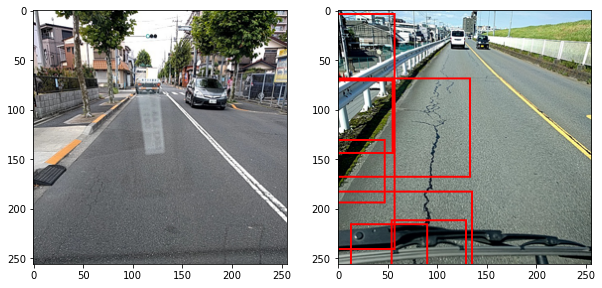

In [29]:
show_images(val_image_ids[0:4], val_predictions)

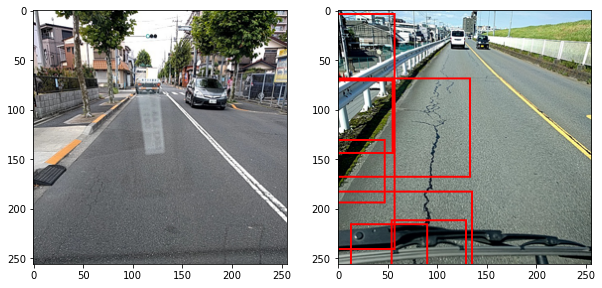

In [30]:
show_images(val_image_ids[0:2], val_predictions)

## Evaluate Model

With the model trained it's time to look at the quality of the model. Begin by plotting the loss curve.

In [31]:
print('Epochs: ' + str(len(history.history['loss'])))
print('Final training loss: ' + str(history.history['loss'][-1]))
print('Final validation loss: ' + str(history.history['val_loss'][-1]))

Epochs: 49
Final training loss: 0.25867342948913574
Final validation loss: 0.29891347885131836


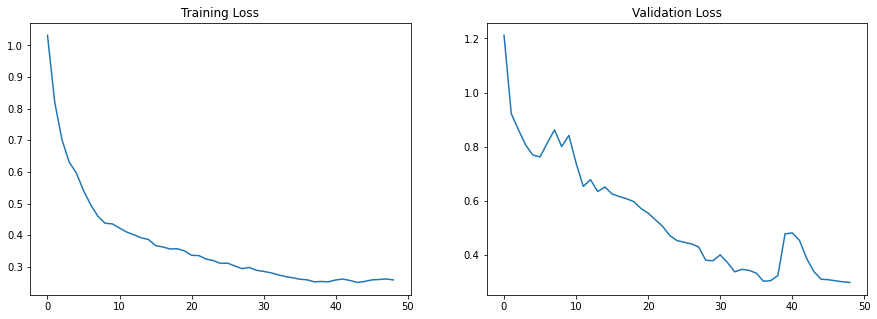

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'])

Finally save the weights so that the model can be used in an inference notebook.

In [33]:
model.save_weights('road_damage_detection_model')

## Conclusion

#### YOLO model has been selected due to it's performance on real time and fatser object detection. We are going to us this model in real time computer vision application. So compared R-CNN and SSD object detection model YOLO is the best fit for our purpose. 

#### YOLO model doing well in this object detection project for detetcting road damage. 
 